# Setting

In [1]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraModel, BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.random.set_seed(111)
np.random.seed(111)

BATCH_SIZE = 8
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_SEQUENCE_LEN = 512

# BERT Fine Tuning (어색한 문장 학습)

## Data Load

In [3]:
DATA_PATH = '../../3.data/BERT/'
PAIRDATA_PATH = 'sentencePairData.csv'

In [4]:
data_df = pd.read_csv(DATA_PATH + PAIRDATA_PATH, index_col=0)
data_df.columns = ['first_sentence', 'second_sentence', 'label']
# data_df = data_df.astype({'first_sentence':'str', 'second_sentence':'str'}) # 숫자로된 데이터를 문자열로 변경
data_df.head()

,first_sentence,second_sentence,label
0,"둘째, ICT 산학협력 SW 교에서는 오답 노트 시스템을 개발했습니다.",네 좋아해요,0
1,금융업계에서의 올해 최고 이슈는 ‘핀테크’입니다.,"은행을 비롯해 모든 금융업계는 IT인프라를 늘리고, 관련 부서를 신설하는 등 핀테크...",1
2,이러한 열정과 도전정신은 저의 인생 모토가 되었고 어떠한 위기와 역경에도 일단 부딪...,학생회를 통해 리더십과 책임감을 발휘할 수 있었으며 혼자가 아닌 팀으로 하여 더 효...,0
3,업무일지 작성으로 사내 인력과 상황에의 대처능력과 조직적응력을 빠르게 나타내겠습니다.,"선수들이 거세게 항의를 하면 판정을 번복하기도 하고, 스로인 반칙을 보고도 그냥 넘...",0
4,카드는 여행 구성에 상관없이 반드시 쓰는 혜택을 구성하고 O2O 서비스를 통해 고객...,신한 판클럽은 야 놀자 하고 제휴는 맺었지만 여행지나 렌터카 등 부가적인 서비스는 ...,1


In [5]:
test_set_ratio = 0.2
test_set_df = data_df[data_df.label == 0].sample(frac=test_set_ratio)
test_set_df = pd.concat([test_set_df, data_df[data_df.label == 1].sample(frac=test_set_ratio)])

train_set_df = data_df.drop(test_set_df.index)
train_set_df.reset_index(inplace=True)
test_set_df.reset_index(inplace=True)

print("train_set: {}개".format(len(train_set_df)))
print("test_set: {}개".format(len(test_set_df)))

train_set: 260530개
test_set: 65132개


In [6]:
train_sentencePair = []
test_sentencePair = []

train_labels = np.asarray(train_set_df['label'].tolist(), dtype=np.int32)
test_labels = np.asarray(test_set_df['label'].tolist(), dtype=np.int32)

for i in range(len(train_set_df)):
    temp_df = train_set_df.iloc[i]
    train_sentencePair.append([temp_df['first_sentence'], temp_df['second_sentence']])
    
for i in range(len(test_set_df)):
    temp_df = test_set_df.iloc[i]
    test_sentencePair.append([temp_df['first_sentence'], temp_df['second_sentence']])
    
len(train_sentencePair), len(test_sentencePair)

(260530, 65132)

## BertTokenizer

In [7]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

# train set 토크나이징
train_encoded_dict = tokenizer(train_sentencePair,
                         padding=True,
                         truncation=True,
                         max_length=MAX_SEQUENCE_LEN,
                         return_tensors='tf')
# test set 토크나이징
test_encoded_dict = tokenizer(test_sentencePair,
                         padding=True,
                         truncation=True,
                         max_length=MAX_SEQUENCE_LEN,
                         return_tensors='tf')

In [8]:
train_inputs = (train_encoded_dict['input_ids'], train_encoded_dict['attention_mask'], train_encoded_dict['token_type_ids'])
test_inputs = (test_encoded_dict['input_ids'], test_encoded_dict['attention_mask'], test_encoded_dict['token_type_ids'])

## Create Model

In [9]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFElectraModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                               kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                               name='classifier')
    
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        # BERT모델 적용
        outputs = self.bert(inputs)
        
        # BERT결과 값으로 Fine tuning하기 위한 벡터로 변환
        pooled_output = outputs.last_hidden_state # [batch_size, sequence_length, hidden]
        pooled_output = pooled_output[:, 0, :]    # take <s> token (equiv. to [CLS]) [batch_size, hidden]
        
        # Fine tuning
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits

cls_model = TFBertClassifier(model_name='monologg/koelectra-base-v3-discriminator',
                            dir_path='bert_ckpt',
                            num_class=2)

Some layers from the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [11]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
model_name = 'tf2_awkward_sentence'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join('./', model_name, 'weights-{epoch:02d}.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} Directory already exists\n",format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} Directory create complete\n",format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_inputs, train_labels,
                       epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                       callbacks=[es_callback, cp_callback])

{} Directory already exists
 ./tf2_awkward_sentence
Epoch 1/3
26053/26053 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9261WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).

Epoch 00001: val_accuracy improved from -inf to 0.93504, saving model to ./tf2_awkward_sentence\weights-01.h5
26053/26053 [==============================] - 8336s 320ms/step - loss: 0.1769 - accuracy: 0.9261 - val_loss: 0.1537 - val_accuracy: 0.9350
Epoch 2/3
26053/26053 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9575
Epoch 00002: val_accuracy improved from 0.93504 to 0.94452, saving model to ./tf2_awkward_sentence\weights-02.h5
26053/26053 [==============================] - 8458s 325ms/step - loss: 0.1084 - accuracy: 0.9575 - val_loss: 0.1443 - val_ac

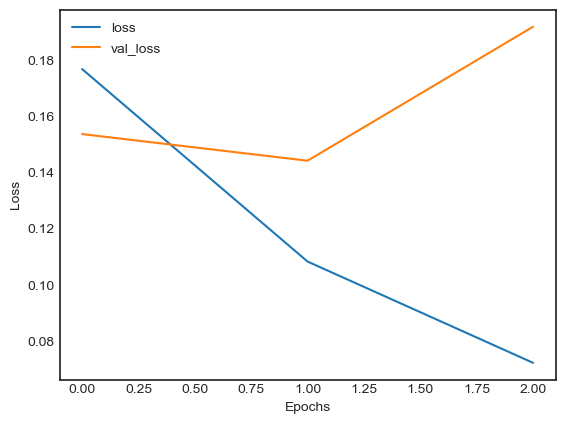

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Preference

In [14]:
cls_model.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)

49997it [00:10, 4676.67it/s]


# Prediction

## 입력 텍스트

In [14]:
text = \
'''"항상 기록하고, 새로운 것을 두려워 하지 않는 개발자"

나날이 발전하는 개발 skill들 속에서 개발자에게 새로운 학습은 필수적입니다. 하지만 유튜브 영상, 논문과 같은 양질의 자료들을 단순히 기억 속에 남기거나, 실습을 한두번 하는 것만으로는 온전히 자기 것으로 만들지 못하고 시간이 지나면 잊혀질 것입니다. 따라서 저는 저의 성장을 기록해 이를 토대로 저의 부족한 점을 피드백 하는 등, 항상 성장하는 개발자를 목표로 하고 있습니다.

대학생때 프로그래밍에 입문하고서부터 초보적인 부분이라도 제가 짠 코드를 기록하곤 하였습니다. 개발자는 글보다는 코드로 얘기한다고 생각해, 블로그보다는 github를 애용하였습니다. 다양한 알고리즘을 익히기 위해 백준 문제들을 풀고 이를 알고리즘 분류별로 github에 정리해 두곤 했습니다. Spring과 같은 웹 백엔드 skill들을 익히고 난 뒤 해커톤 등 팀 프로젝트 결과물 또한 github에 항상 기록하였습니다. 가끔 이를 되돌아보며 저의 행적에 대한 피드백과 앞으로 어떤 skill을 익혀야 하는지 계획을 수립해 새로운 성장을 도모하고 있습니다.

지금까지도 여러 코드들을 기록해왔지만, 앞으로는 이론적인 부분 역시 기록할 생각입니다. velog와 같은 블로그에 업무와 관련된 이론적 사항, 개인적인 공부 등 다양한 글을 올려 후배 개발자들에게 도움이 되고, 선배 개발자들에게 피드백을 받아 모난 부분을 조금씩 개선시켜 나갈 생각입니다.
만일 Naver 영화 서비스 개발 팀에 합류한다면 여러 선배 개발자 분들하고 다양한 영화 서비스 개발을 할 것 같습니다. 개발을 수행하면서 배워야 하는 skill, 코드 리뷰를 통해 배운 Clean Code 등 여러 사항을 기록해 나가면서 선배 개발자 분들처럼 끊임없이 성장하는 개발자가 되고 싶습니다.'''

## 입력 텍스트 전처리

In [15]:
from ReAIPreprocessor import Preprocessor

In [ ]:
predictions = model.predict(x_test[:3])

In [ ]:
for predict in predictions:
    print(np.array(prediction).argmax())

label = predictions[0].argmax()
label
confidence = predictions[0][predictions[0].argmax()]
confidence
# print(label, confidence) #